## Objective
Compare RT-Sort (prop_signal) to kilosort

## General setup

In [1]:
%load_ext autoreload

In [2]:
from importlib import reload
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

%autoreload 2
from src import utils, plot
from src.comparison import Comparison
from src.sorters.base import SpikeSorter, Unit
from src.sorters.kilosort import get_experts_kilosort

from src.run_alg import si_rec9 as F

In [5]:
# From si_rec6.ipynb

# TRAINING_FRAMES for forming sequences while TESTING_FRAMES if for comparing with kilosort
# CALLED FRAMES BUT IS ACTUALLY IN ms
TRAINING_MS = (0, 5*60*1000)  # 0 min to 5 min in recording (in ms)
TESTING_MS = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording (in ms)

RECORDING = utils.rec_si()
CHANS_RMS = utils.chans_rms_si()

SAMP_FREQ = RECORDING.get_sampling_frequency()
NUM_ELECS = RECORDING.get_num_channels()
ELEC_LOCS = RECORDING.get_channel_locations()

ALL_CLOSEST_ELECS = []
for elec in range(NUM_ELECS):
    elec_ind = []
    dists = []
    x1, y1 = ELEC_LOCS[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = ELEC_LOCS[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   
    
MODEL_TRACES_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/model_traces.npy"
MODEL_OUTPUTS_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/model_outputs.npy"
FRONT_BUFFER = 60  # Model's front sample buffer

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


Recording does not have scaled traces. Setting gain to 0.195


In [6]:
# Set global variables in .py
reload(F)

F.RECORDING = RECORDING
F.CHANS_RMS = CHANS_RMS
F.SAMP_FREQ = SAMP_FREQ
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS

F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

F.MODEL_OUTPUTS_PATH = MODEL_OUTPUTS_PATH
F.FRONT_BUFFER = FRONT_BUFFER

F.TRACES = np.load(MODEL_TRACES_PATH, mmap_mode="r")
F.OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")

In [7]:
# kilosort = Kilosort(utils.PATH_SM4_SI, "first", RECORDING)
# kilosort = get_experts_kilosort(testing_ms=TESTING_FRAMES)
kilosort = get_experts_kilosort(testing_ms=TESTING_MS)

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/data/MEAprojects/PropSignal/src/sorters/kilosort.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array([spikes1[idx] for idx in range(len(comp.match12)) if comp.match12[idx] != -1])
/home/mea/anaconda3/envs/

Recording does not have scaled traces. Setting gain to 0.195


In [ ]:
# Testing KS overlap with 4RMS detections
# all_ks_spikes = []
# for times in kilosort.get_spike_times():
#     all_ks_spikes.extend(times)
# all_ks_spikes = np.sort(all_ks_spikes)

# # crossings = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/all_crossings.npy",allow_pickle=True)
# # overlap_time = 0.1
# # crossings_curated = [crossings[0][1]]
# # for elec, time, amp in crossings[1:]:
# #     if start_ms <= time <= end_ms:
# #         if time - crossings_curated[-1] > overlap_time:
# #             crossings_curated.append(time)

# crossings_curated = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231128/delete_me.npy")

# matches = Comparison.count_matching_events(all_ks_spikes, crossings_curated)
# print(matches/len(all_ks_spikes))
# print(matches/len(crossings_curated))

In [7]:
# Create all_ks_units with self.templates and self.chan set --> Don't run this if already ran before
all_ks_units = []

def job(idx):
    unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
    templates = unit.get_templates()
    unit.templates = templates
    unit.recording = None
    unit.chan = np.argmin(np.min(templates, axis=1))
    return unit

all_ks_spike_times = kilosort.get_spike_times()
with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
        unit.recording = RECORDING
        all_ks_units.append(unit)

100%|██████████| 226/226 [05:25<00:00,  1.44s/it]


In [8]:
chan_to_ks_units = {}
for unit in all_ks_units:
    if unit.chan not in chan_to_ks_units:
        chan_to_ks_units[unit.chan] = [unit]
    else:
        chan_to_ks_units[unit.chan].append(unit)

In [10]:
prop_signal = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240225/prop_signal.pickle")
# all_prop_units = []
# chan_to_prop_units = {}

# for unit in prop_signal:
#     unit.recording = RECORDING
#     chan = np.argmax(unit.mean_amps)
#     unit.chan = chan
#     if chan not in chan_to_prop_units:
#         chan_to_prop_units[chan] = [unit]
#     else:
#         chan_to_prop_units[chan].append(unit)
#     all_prop_units.append(unit)

## Compare ISIs

Kilosort


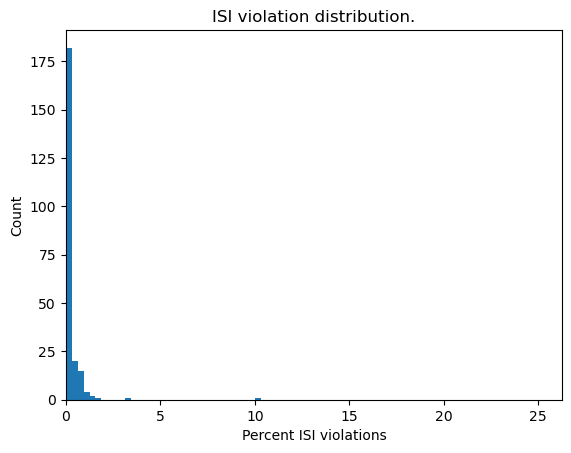

7
RT-Sort


/data/MEAprojects/PropSignal/src/sorters/base.py:486: RuntimeWarning: invalid value encountered in long_scalars
  violations.append(violation_num / len(st) * 100)


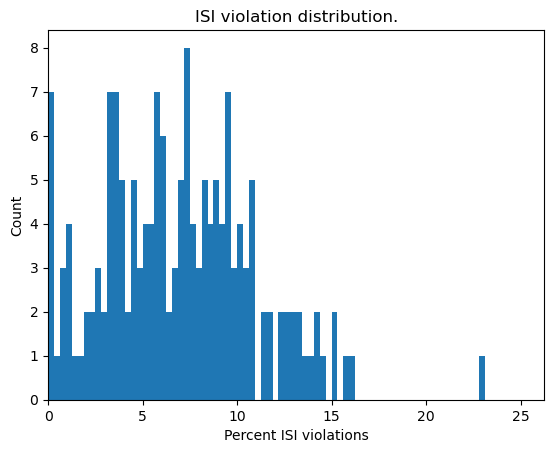

152
42
327
182
27
136
569
524
556
1879
605
1111
740
718
310
375
2124
1973
1061
274
661
537
722
407
999
1101
793
335
52
668
807
494
566
201
383
638
389
856
741
424
128
149
136
149
228
31
29
77
96
32
32
83
123
197
84
45
109
6
4
12
17
100
67
50
40
119
68
75
260
25
253
787
296
437
0
562
142
359
101
6
8
7
6
8
24
7
2
8
2
5
22
8
15
143
281
117
578
779
0
686
389
1347
527
329
313
329
272
353
550
353
572
212
352
589
176
237
0
1
1
2
1
0
0
1
0
0
1
0
6
52
13
38
81
15
266
110
185
130
61
111
55
143
273
115
324
77
205
211
618
299
106
116
321
255
301
223
46
94
41
42
147
70
13
37
5
13


In [15]:
print("Kilosort")
isis = kilosort.plot_isis(bins=80, range=(0, 25))
print(np.sum(np.array(isis) > 1))
plt.show()

print("RT-Sort")
isis = prop_signal.plot_isis(bins=80, range=(0, 25))
print(np.sum(np.array(isis) > 1))
plt.show()
for unit in prop_signal.units:
    isis = np.diff(np.sort(unit.spike_train))
    viols = isis <= 1.5
    print(np.sum(viols))

In [ ]:
bounds[:-1] + np.diff(bounds)/2

array([-6.66666667e-01, -5.55111512e-17,  6.66666667e-01])

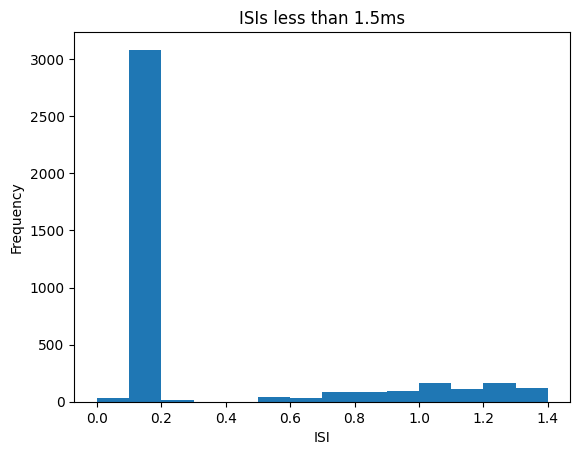

74.3% of ISIs are less than 0.5ms


In [44]:
data = []
for spike_train in prop_signal.get_spike_times():
    isis = np.diff(spike_train)
    viols = isis <= 1.5
    # if np.sum(viols) / len(spike_train) > 0.01:
    data.extend(isis[viols])
data = np.array(data)

plt.hist(data, bins=np.arange(0, 1.5, 0.1))
plt.xlabel("ISI")
plt.ylabel("Frequency")
plt.title("ISIs less than 1.5ms")
plt.show()

print(f"{np.sum(data <= 0.5)/len(data)*100:.1f}% of ISIs are less than 0.5ms")

## Base comparison

Num RT-Sort: 338
Num Experts Kilosort: 226

Spikeinterface formula
19/338 matches
21/338 max matches

For RT-Sort:
Num max matches: 21
Num unique max matches: 19

For Experts Kilosort:
Num max matches: 21
Num unique max matches: 19


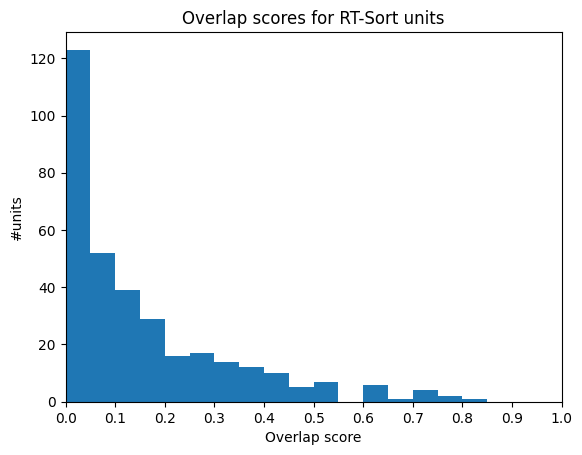

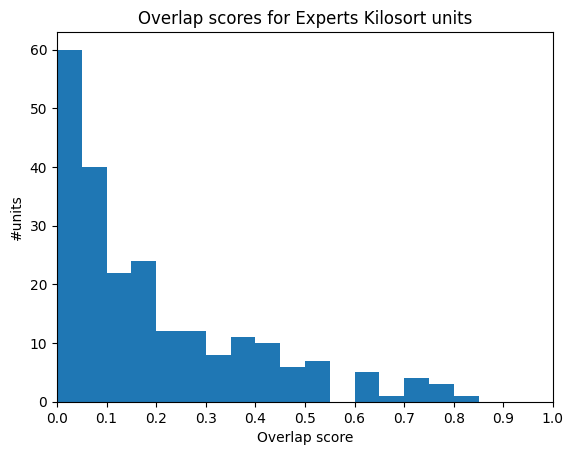

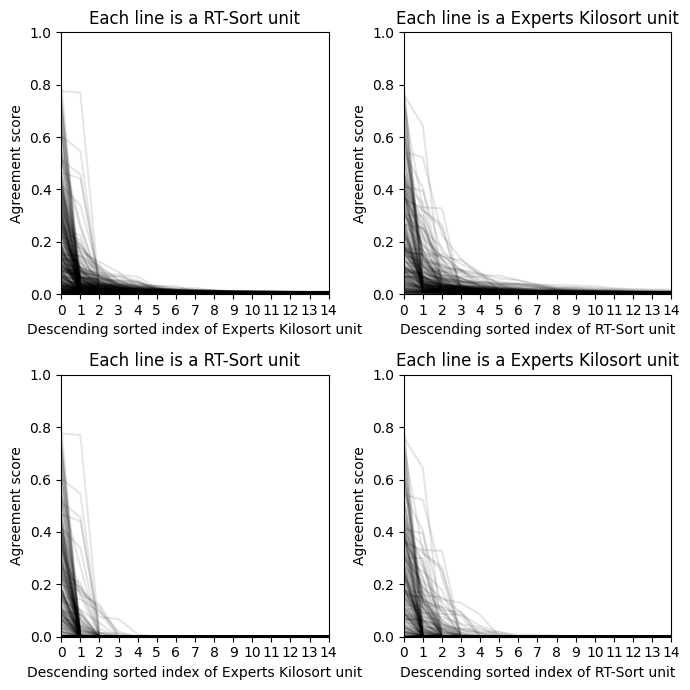

Num RT-Sort: 338
Num Experts Kilosort: 226

#matches/#rt_sort
73/338 matches
126/338 max matches

For RT-Sort:
Num max matches: 126
Num unique max matches: 72

For Experts Kilosort:
Num max matches: 75
Num unique max matches: 71


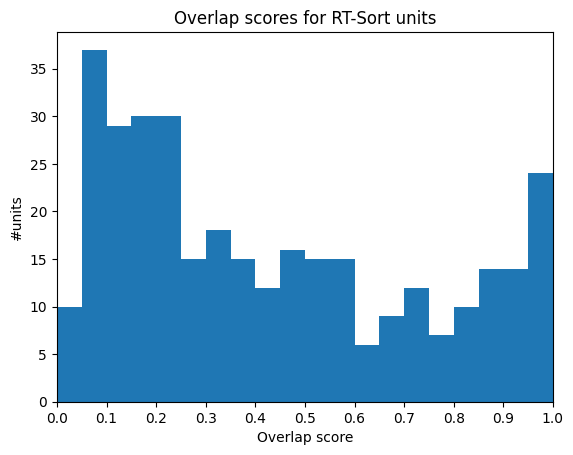

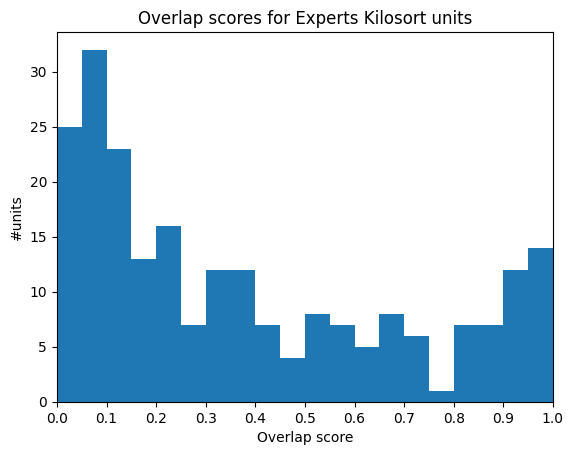

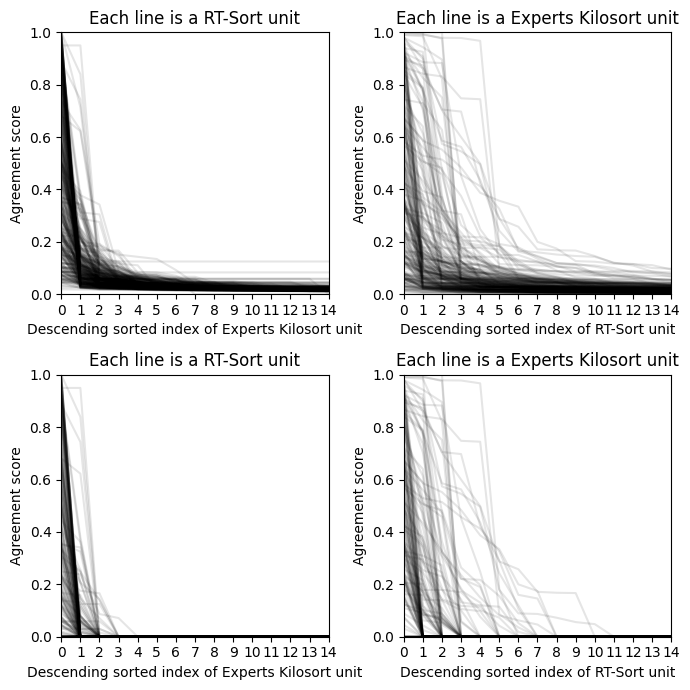

Num RT-Sort: 338
Num Experts Kilosort: 226

#matches/#kilosort
38/338 matches
41/338 max matches

For RT-Sort:
Num max matches: 41
Num unique max matches: 38

For Experts Kilosort:
Num max matches: 46
Num unique max matches: 38


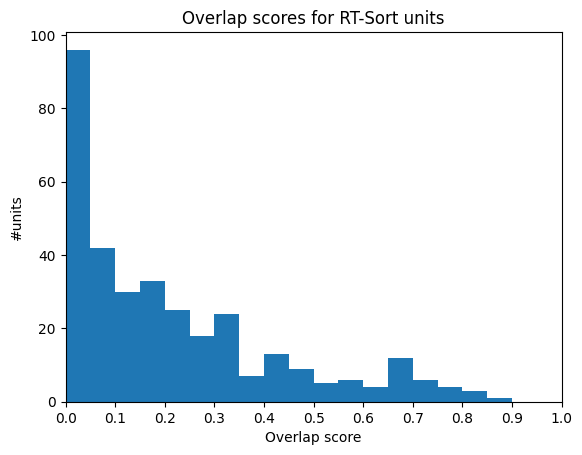

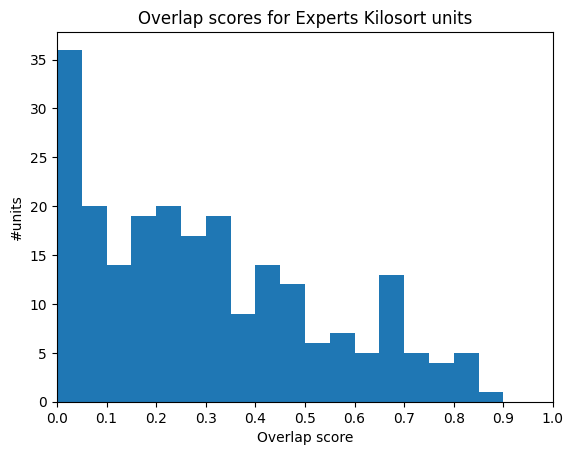

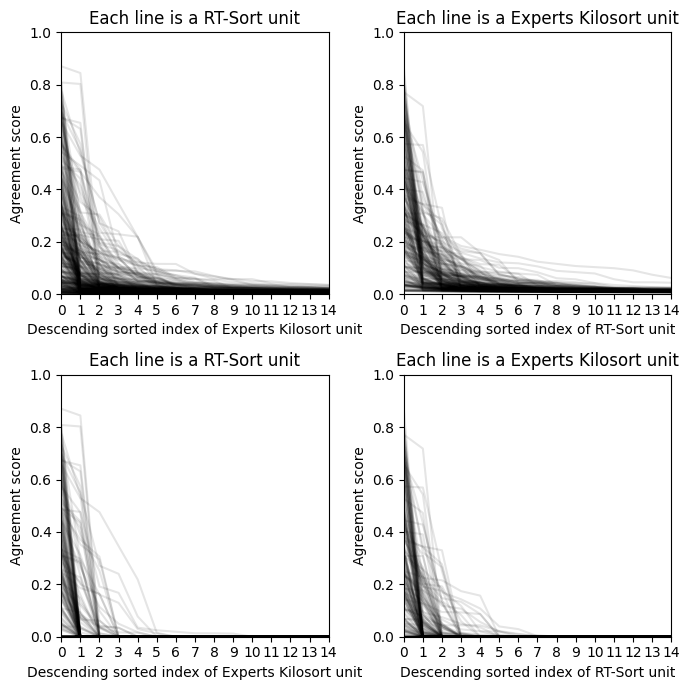

In [47]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
comp_1_5.summary()
comp_1_5.plot_line_comps()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1, delta_time=0.4)
comp_1.summary()
comp_1.plot_line_comps()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2, delta_time=0.4)
comp_2.summary()
comp_2.plot_line_comps()

In [45]:
prop_train = set()
for spike_train in prop_signal.get_spike_times():
    prop_train.update(spike_train)
prop_train = np.sort(list(prop_train))

ks_train = set()
for spike_train in kilosort.get_spike_times():
    ks_train.update(spike_train)
ks_train = np.sort(list(ks_train))

num_matches = Comparison.count_matching_events(prop_train, ks_train,
                                               delta=0.4)
print(f"#spikes:")
print(f"Matches: {num_matches}")
print(f"RT-Sort: {len(prop_train)}, {num_matches/len(prop_train)*100:.1f}")
print(f"Kilosort: {len(ks_train)}, {num_matches/len(ks_train)*100:.1f}")

#spikes:
Matches: 194651
RT-Sort: 266922, 72.9
Kilosort: 347992, 55.9


## Above 5RMS

score formula 1.5


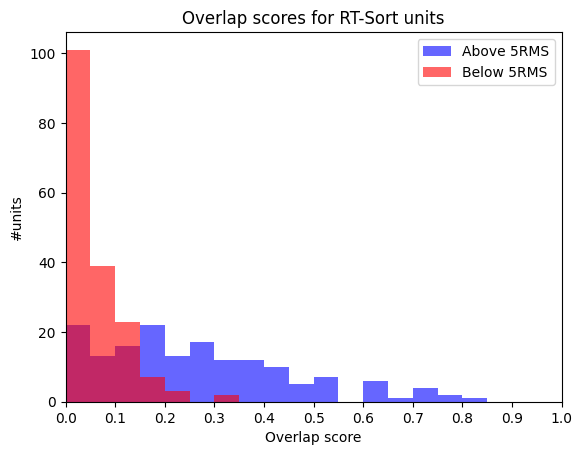

score formula 1


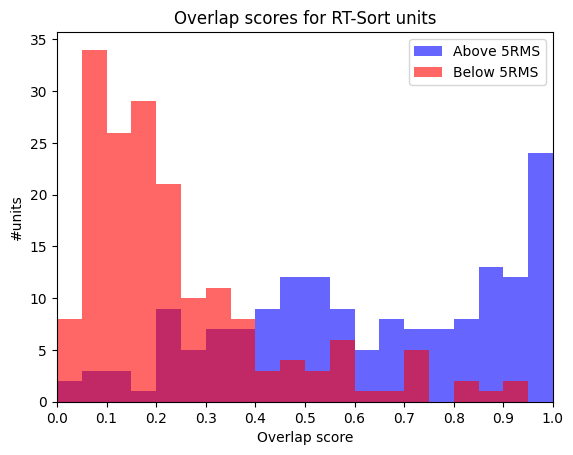

score formula 2


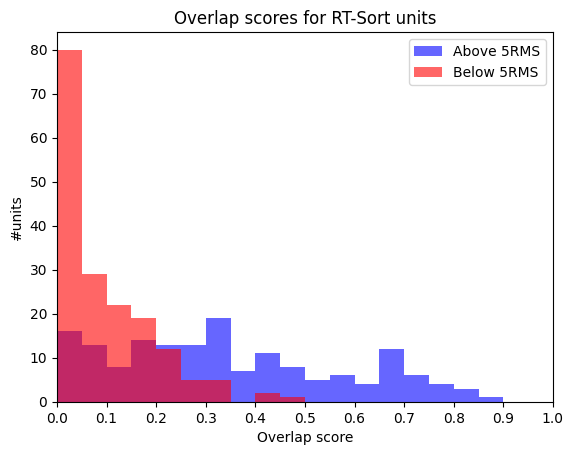

163 above 5RMS, 175 below 5RMS


In [48]:
for comp in (comp_1_5, comp_1, comp_2): 
    print(f"score formula", comp.score_formula)
    scores_above = []  # Overlap scores for units above 5RMS
    scores_below = []  # Overlap scores for units fully below 5RMS
    for idx, unit in enumerate(prop_signal):
        chans_above = unit.mean_amps >= 5  # CHANS_RMS * 5
        scores = comp.agreement_scores[idx, :]
        score = np.max(scores)
        if np.sum(chans_above) > 0:
            scores_above.append(score)
        else:
            scores_below.append(score)
    
    plt.title(f"Overlap scores for RT-Sort units")
    plt.hist(scores_above, range=(0, 1), bins=20, alpha=0.6, color="blue", label="Above 5RMS")
    plt.hist(scores_below, range=(0, 1), bins=20, alpha=0.6, color="red", label="Below 5RMS")
    
    plt.xlabel("Overlap score")
    plt.xticks([x/10 for x in range(11)])
    plt.ylabel("#units")
    plt.xlim(0, 1)
    # plt.ylim(0, 60)
    plt.legend()
    plt.show()
print(f"{len(scores_above)} above 5RMS, {len(scores_below)} below 5RMS")

## Only prop spikes within kilosort spikes

In [49]:
prop_units = [unit for unit in prop_signal]
within_prop_units, outside_prop_units = F.select_prop_spikes_within_kilosort_spikes(prop_units, all_ks_units,
                                                                                    max_ms_dist=0.4, max_micron_dist=200)
for unit, within, outside in zip(prop_units, within_prop_units, outside_prop_units):
    within.mean_amps = unit.mean_amps
    outside.mean_amps = unit.mean_amps

42.8%


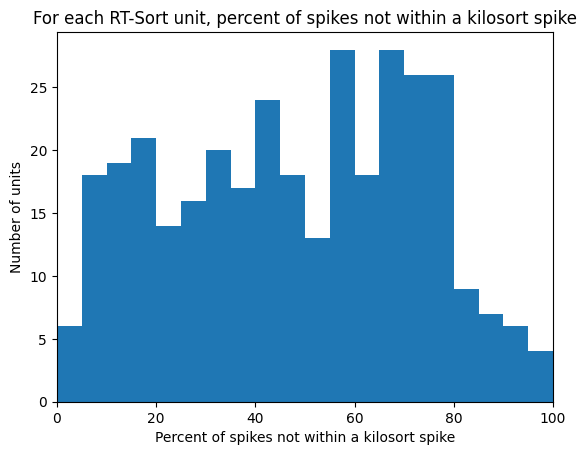

In [51]:
outside_percents = []
total_within = 0
total_outside = 0
for within, outside in zip(within_prop_units, outside_prop_units):
    within, outside = len(within.spike_train), len(outside.spike_train)
    total_within += within
    total_outside += outside
    if outside+within == 0:
        outside_percents.append(0)
    else:
        outside_percents.append(outside / (outside+within) * 100)

print(f"{total_outside/(total_within + total_outside)*100:.1f}%")
plot.hist(outside_percents, xlim=(0, 100), bins=20)
plt.title("For each RT-Sort unit, percent of spikes not within a kilosort spike")
plt.xlabel("Percent of spikes not within a kilosort spike")
plt.ylabel("Number of units")
plt.show()

In [15]:
prop_signal_within_ks = SpikeSorter(RECORDING, "RT-Sort", units=[unit for unit in within_prop_units if len(unit.spike_train) > 0])

Num RT-Sort: 334
Num Experts Kilosort: 226

Spikeinterface formula
14/334 matches
14/334 max matches

For RT-Sort:
Num max matches: 14
Num unique max matches: 14

For Experts Kilosort:
Num max matches: 16
Num unique max matches: 14


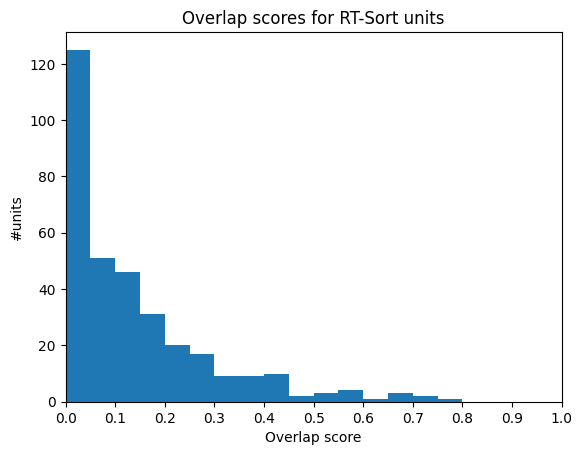

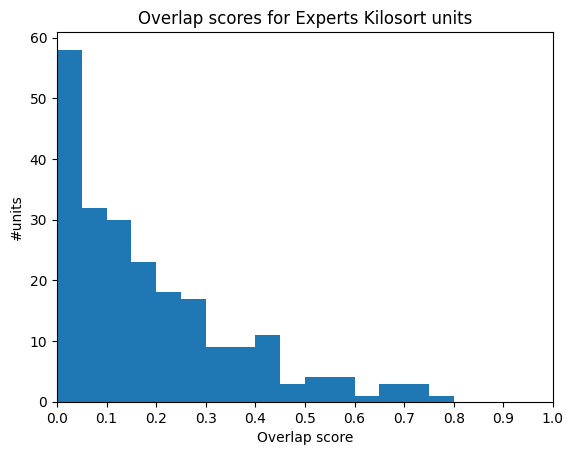

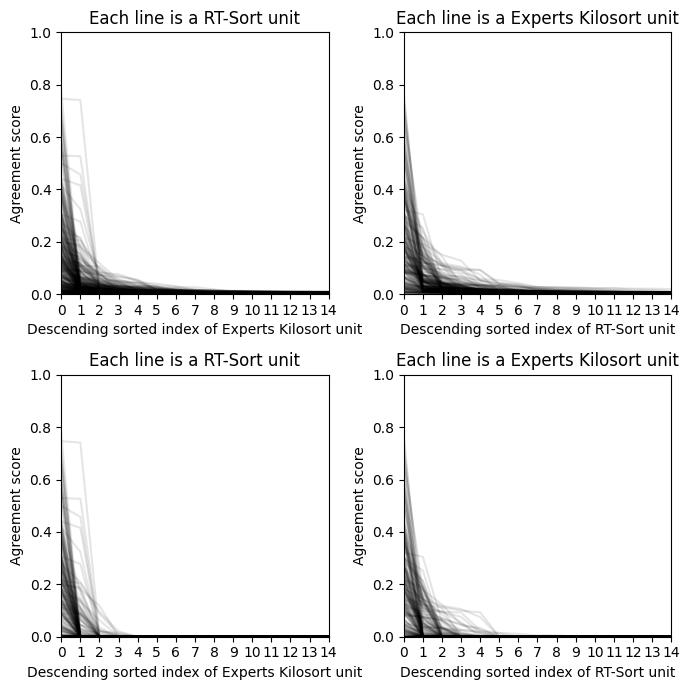

Num RT-Sort: 334
Num Experts Kilosort: 226

#matches/#rt_sort
94/334 matches
184/334 max matches

For RT-Sort:
Num max matches: 184
Num unique max matches: 92

For Experts Kilosort:
Num max matches: 97
Num unique max matches: 91


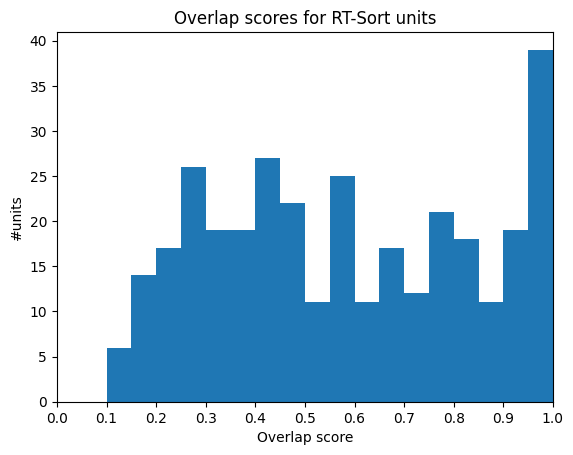

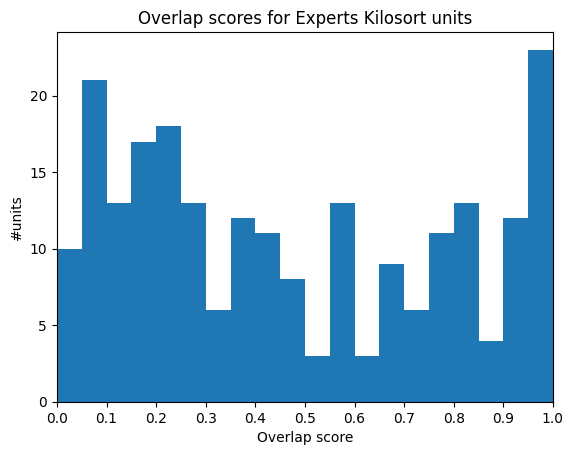

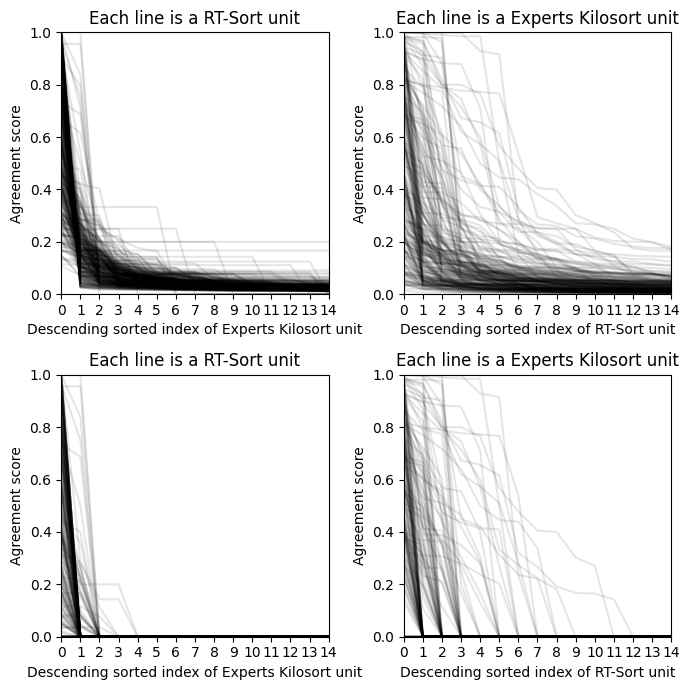

Num RT-Sort: 334
Num Experts Kilosort: 226

#matches/#kilosort
28/334 matches
28/334 max matches

For RT-Sort:
Num max matches: 28
Num unique max matches: 28

For Experts Kilosort:
Num max matches: 32
Num unique max matches: 28


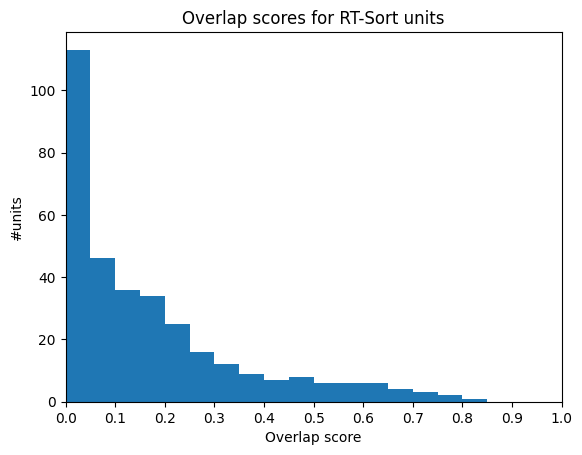

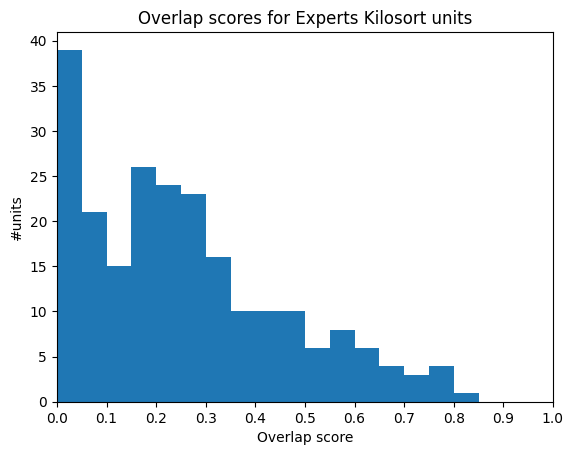

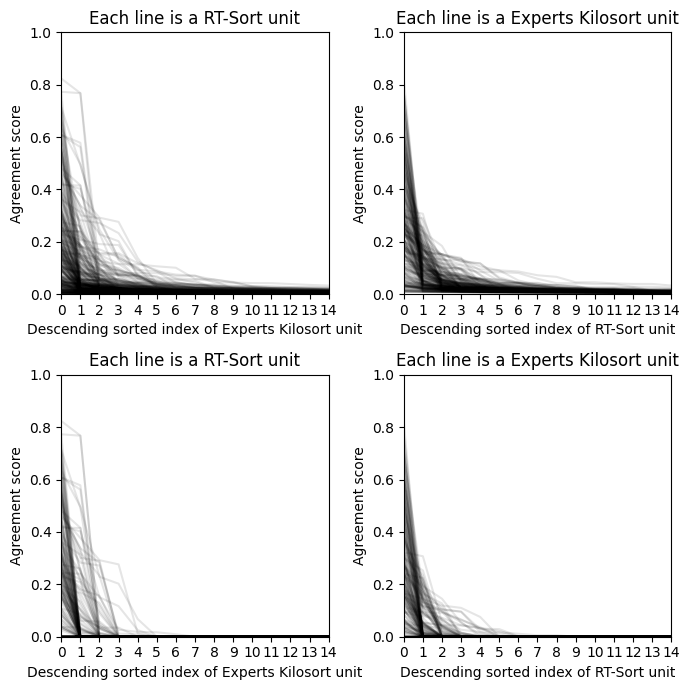

In [16]:
comp_1_5 = Comparison(prop_signal_within_ks, kilosort, score_formula=1.5, delta_time=0.4)
comp_1_5.summary()
comp_1_5.plot_line_comps()

comp_1 = Comparison(prop_signal_within_ks, kilosort, score_formula=1, delta_time=0.4)
comp_1.summary()
comp_1.plot_line_comps()

comp_2 = Comparison(prop_signal_within_ks, kilosort, score_formula=2, delta_time=0.4)
comp_2.summary()
comp_2.plot_line_comps()

In [17]:
prop_train = set()
for spike_train in prop_signal_within_ks.get_spike_times():
    prop_train.update(spike_train)
prop_train = np.sort(list(prop_train))
    
ks_train = set()
for spike_train in kilosort.get_spike_times():
    ks_train.update(spike_train)
ks_train = np.sort(list(ks_train))

num_matches = Comparison.count_matching_events(prop_train, ks_train,
                                               delta=0.4)
print(f"#spikes:")
print(f"Matches: {num_matches}")
print(f"RT-Sort: {len(prop_train)}, {num_matches/len(prop_train)*100:.1f}")
print(f"Kilosort: {len(ks_train)}, {num_matches/len(ks_train)*100:.1f}")

#spikes:
Matches: 158451
RT-Sort: 159150, 99.6
Kilosort: 347992, 45.5


score formula 1.5


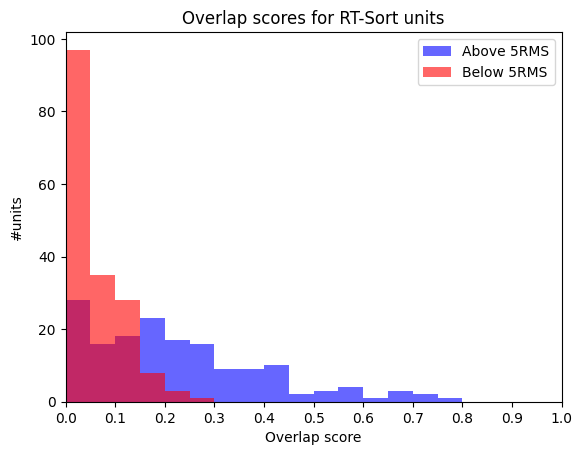

score formula 1


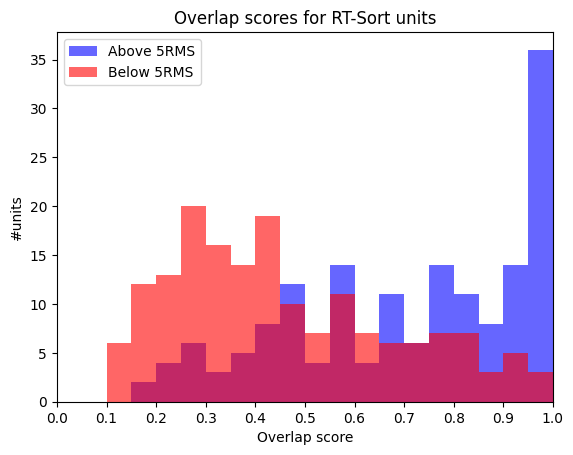

score formula 2


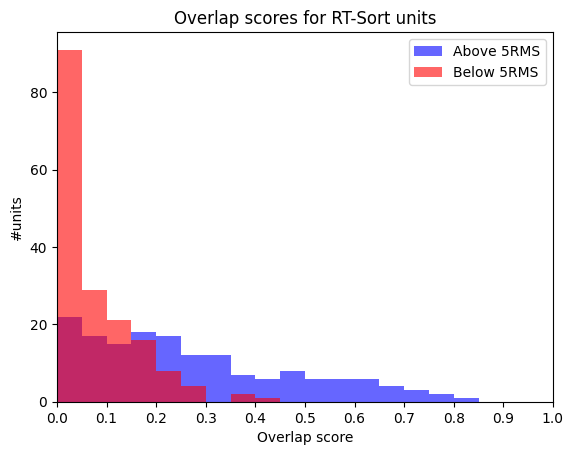

162 above 5RMS, 172 below 5RMS


In [18]:
for comp in (comp_1_5, comp_1, comp_2): 
    print(f"score formula", comp.score_formula)
    scores_above = []  # Overlap scores for units above 5RMS
    scores_below = []  # Overlap scores for units fully below 5RMS
    for idx, unit in enumerate(prop_signal_within_ks):
        chans_above = unit.mean_amps >= 5 # CHANS_RMS * 5
        scores = comp.agreement_scores[idx, :]
        score = np.max(scores)
        if np.sum(chans_above) > 0:
            scores_above.append(score)
        else:
            scores_below.append(score)
    
    plt.title(f"Overlap scores for RT-Sort units")
    plt.hist(scores_above, range=(0, 1), bins=20, alpha=0.6, color="blue", label="Above 5RMS")
    plt.hist(scores_below, range=(0, 1), bins=20, alpha=0.6, color="red", label="Below 5RMS")
    
    plt.xlabel("Overlap score")
    plt.xticks([x/10 for x in range(11)])
    plt.ylabel("#units")
    plt.xlim(0, 1)
    # plt.ylim(0, 60)
    plt.legend()
    plt.show()
print(f"{len(scores_above)} above 5RMS, {len(scores_below)} below 5RMS")

## Only kilosort spikes within prop spikes

In [52]:
within_ks_units, outside_ks_units = F.select_prop_spikes_within_kilosort_spikes(all_ks_units, all_prop_units, 
                                                                                max_ms_dist=0.4, max_micron_dist=200)

54.4%


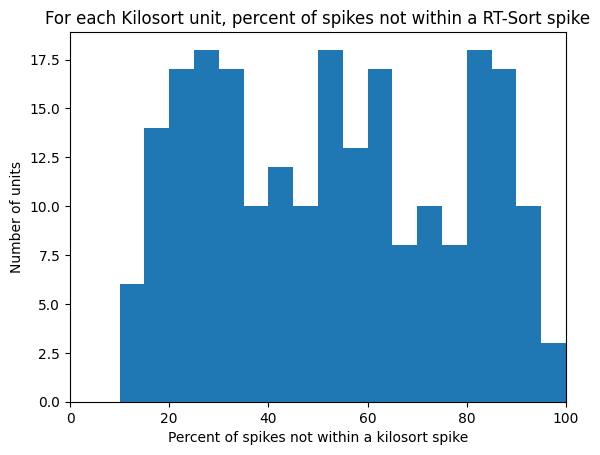

In [53]:
outside_percents = []
total_within = 0
total_outside = 0
for within, outside in zip(within_ks_units, outside_ks_units):
    within, outside = len(within.spike_train), len(outside.spike_train)
    total_within += within
    total_outside += outside
    outside_percents.append(outside / (outside+within) * 100)

print(f"{total_outside/(total_within + total_outside)*100:.1f}%")
plot.hist(outside_percents, xlim=(0, 100), bins=20)
plt.title("For each Kilosort unit, percent of spikes not within a RT-Sort spike")
plt.xlabel("Percent of spikes not within a kilosort spike")
plt.ylabel("Number of units")
plt.show()

In [ ]:
sorted_ind = np.argsort(outside_percents)
for idx in sorted_ind:
    print(idx, outside_percents[idx])

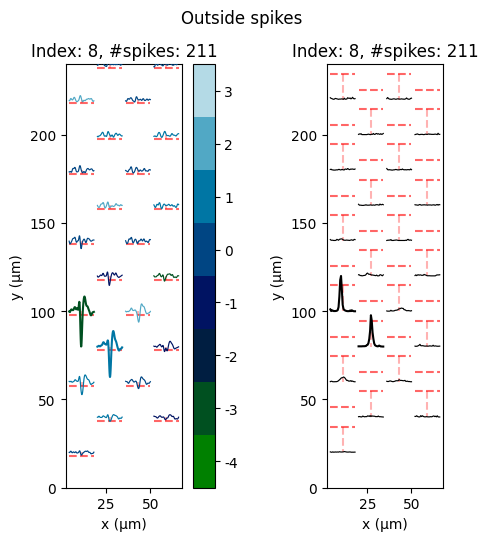

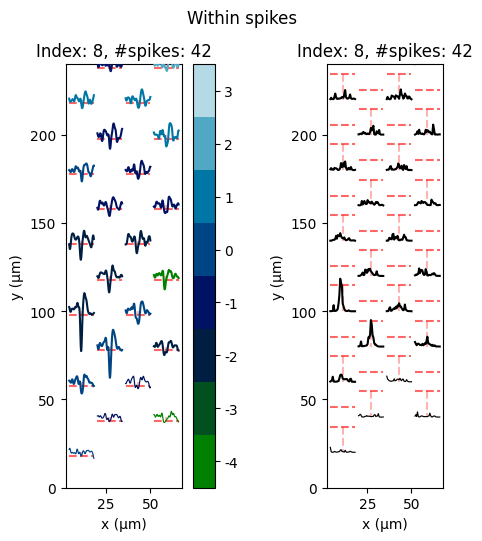

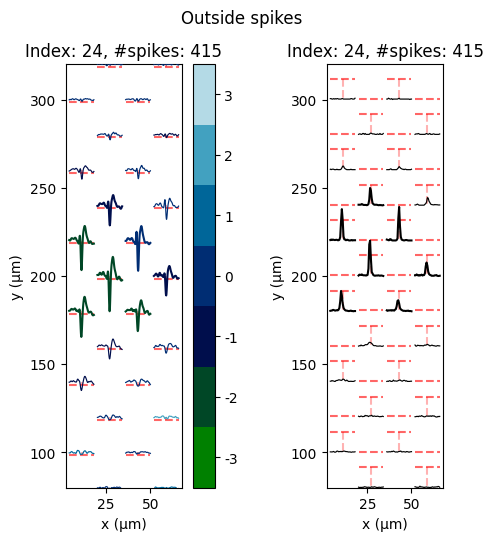

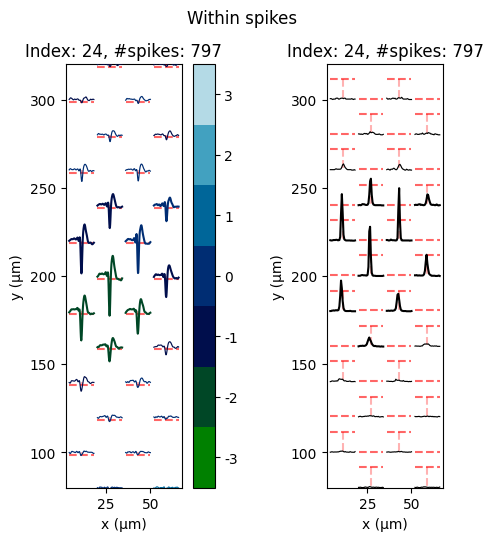

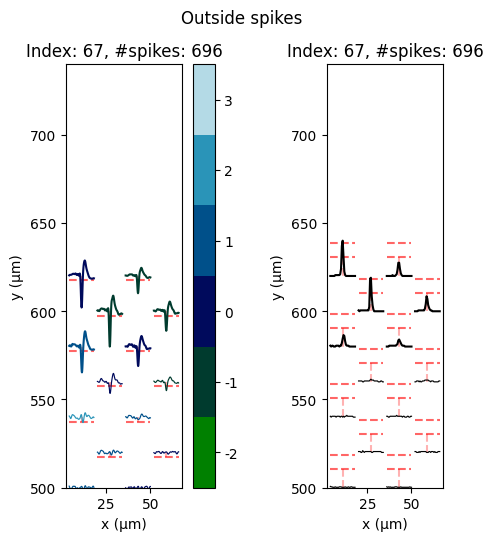

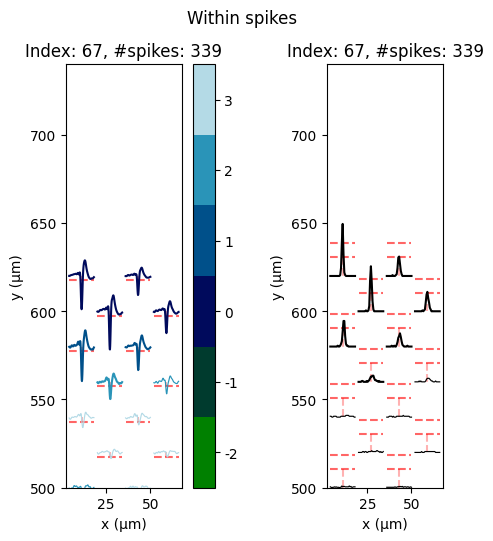

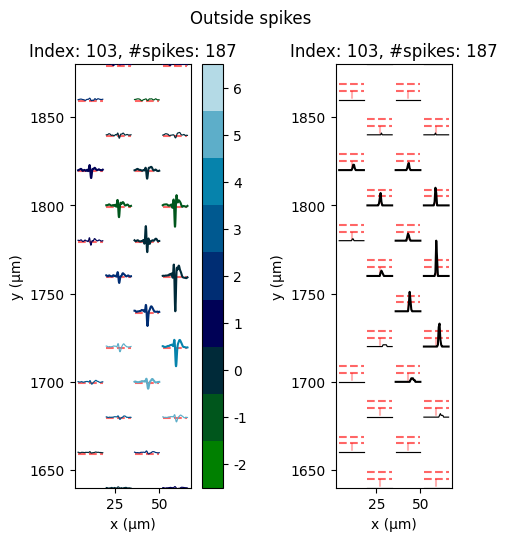

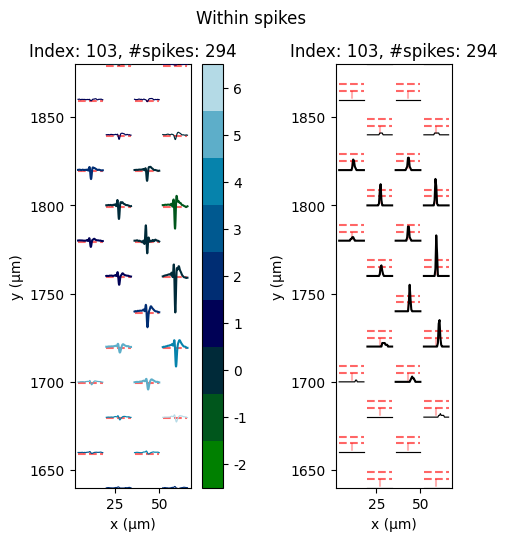

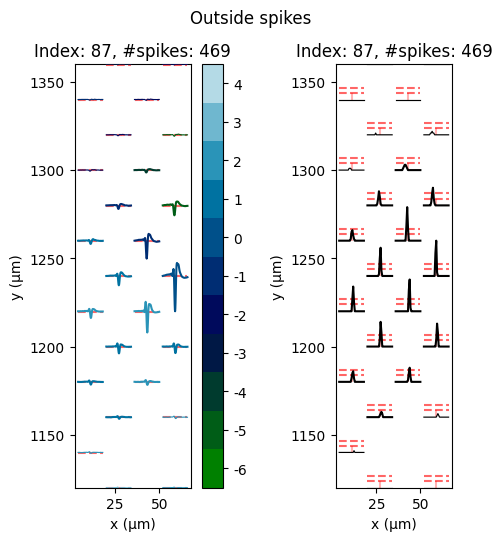

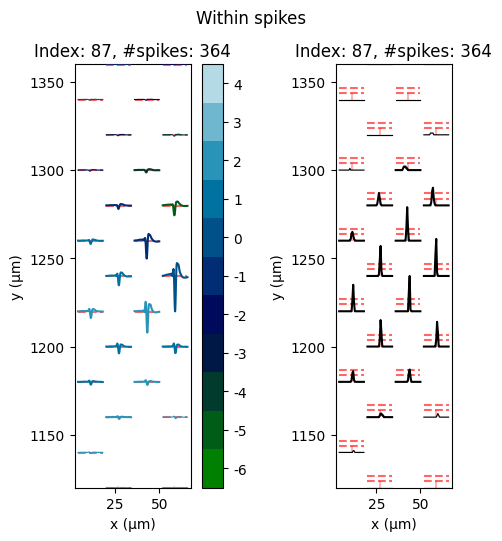

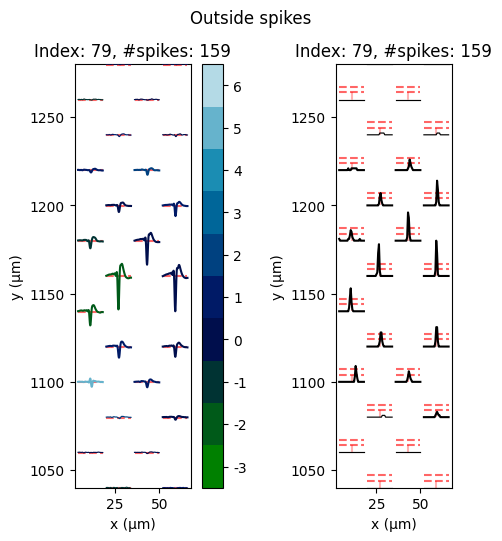

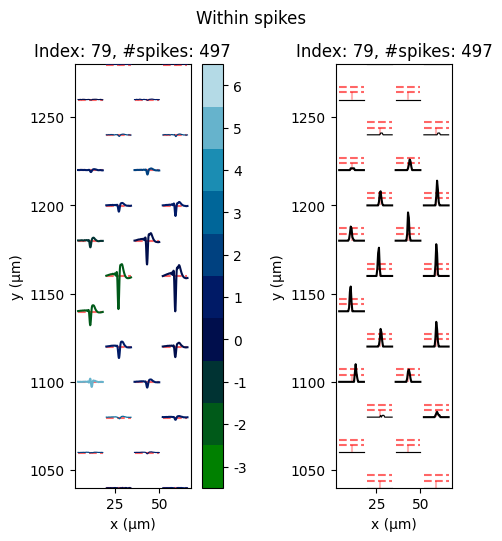

In [55]:
np.random.seed(100)
for idx in np.random.choice(len(within_ks_units), 6):
# for idx in [46, 22, 93, 68]:
    within, outside, outside_percent = within_ks_units[idx], outside_ks_units[idx], outside_percents[idx]

# for within, outside, outside_percent in zip(within_ks_units, outside_ks_units, outside_percents):
    # if outside_percent < 20:
    #     continue
    
    # fig, axes = plt.subplots(1, 2, figsize=(7.2, 4.8))
    # # kwargs = within.plot(subplot=(fig, axes[0]), chans_rms=CHANS_RMS)
    # kwargs = within.plot(axis=axes[0], chans_rms=CHANS_RMS)
    # fig.suptitle(axes[0].get_title())
    # axes[0].set_title(f"{len(within.spike_train)} within spikes")
    # # outside.plot(subplot=(fig, axes[1]), **kwargs)
    # outside.plot(axis=axes[1], chans_rms=CHANS_RMS)# outside.plot(axis=axes[1], **kwargs)
    # axes[1].set_title(f"{len(outside.spike_train)} outside spikes")
    # print(f"{outside_percent:.2f}% percent of spikes not within a RT-Sort spike")
    # plt.show()
    
    outside_unit = outside_ks_units[idx]
    amp_kwargs, prob_kwargs = F.plot_elec_probs(outside_unit)
    plt.suptitle("Outside spikes")
    plt.show()
    
    # F.plot_amp_dist(outside_unit)
    # plt.show()
    
    within_unit = within_ks_units[idx]
    F.plot_elec_probs(within_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.suptitle("Within spikes")
    plt.show()
    
    # F.plot_amp_dist(within_unit)
    # plt.show()

elec: 18, loc: [ 27. 200.]
19.28% percent of spikes not within a RT-Sort spike


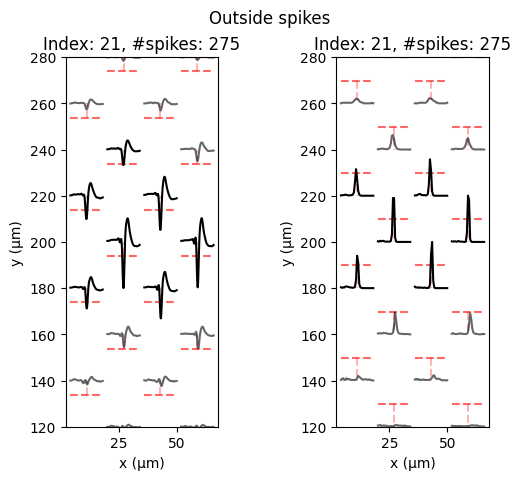

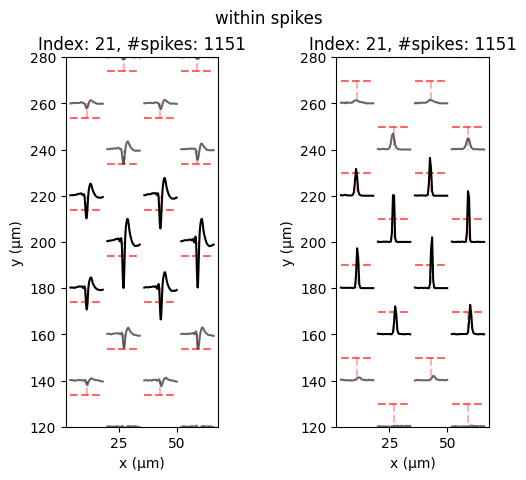

60.10% percent of spikes not within a RT-Sort spike


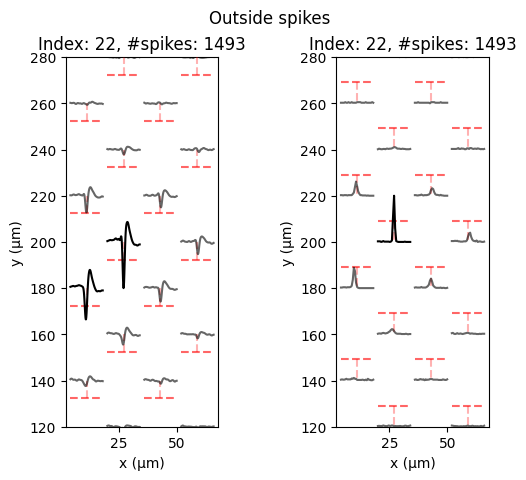

KeyboardInterrupt: 

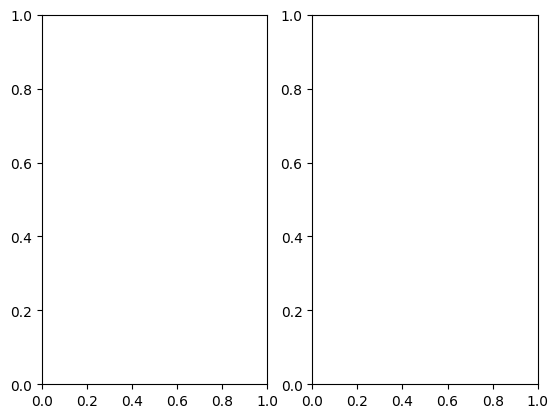

In [31]:
ks_unit = all_ks_units[21]
ks_chan = ks_unit.chan

print(f"elec: {ks_chan}, loc: {ELEC_LOCS[ks_chan]}")

ks_units = chan_to_ks_units[ks_chan]
for unit in ks_units:
    idx = unit.idx
    
    print(f"{outside_percents[idx]:.2f}% percent of spikes not within a RT-Sort spike")
    
    outside_unit = outside_ks_units[idx]
    amp_kwargs, prob_kwargs = F.plot_elec_probs(outside_unit)
    plt.suptitle("Outside spikes")
    plt.show()
    
    # F.plot_amp_dist(outside_unit)
    # plt.show()
    
    within_unit = within_ks_units[idx]
    F.plot_elec_probs(within_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.suptitle("within spikes")
    plt.show()
    
    # F.plot_amp_dist(within_unit)
    # plt.show()

In [32]:
max_prop_idx = np.argsort(-comp_2.agreement_scores[:, idx])[0]
score = comp_2.agreement_scores[max_prop_idx, idx]
print(f"RT-Sort idx: {max_prop_idx}")
print(f"score: {score}")
print(f"#overlaps: {score * len(ks_unit.spike_train)}")

RT-Sort idx: 8
score: 0.2717391304347826
#overlaps: 387.5


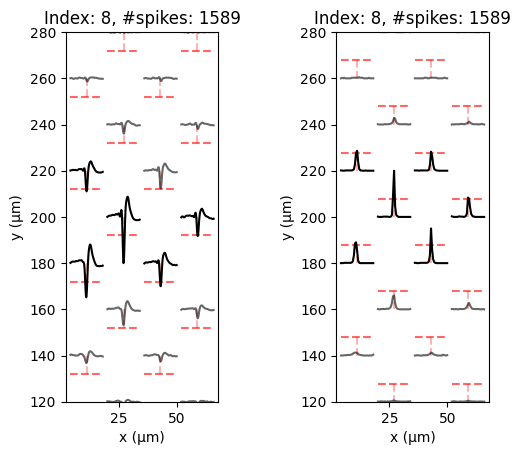

NameError: name 'get_amp_dist' is not defined

In [33]:
prop_units = chan_to_prop_units[ks_chan]
for unit in prop_units:
    F.plot_elec_probs(unit)
    plt.show()
    
    F.plot_amp_dist(unit)
    plt.show()

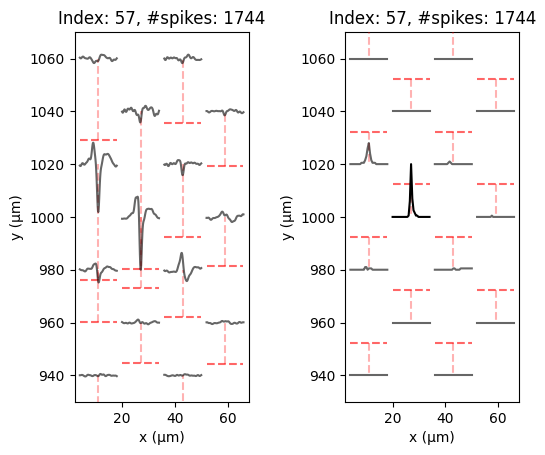

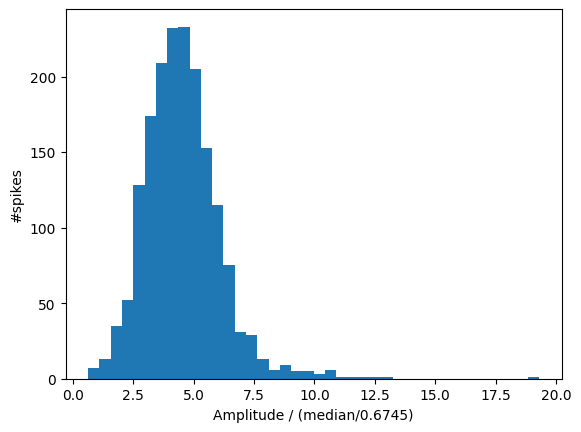

In [97]:
unit = prop_signal[max_prop_idx]
F.plot_elec_probs(unit)
plt.show()

F.plot_amp_dist(unit)
plt.show()

In [121]:
assert False

AssertionError: 